In [24]:
import pandas as pd
import pickle,os, copy
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import sys
sys.path.append("..")
from nets import Nets
from utils import *

import re

from sklearn.cluster import DBSCAN

from interpolation import *


from postprocessing import *
from analysis import *

%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = (13,9)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [6]:
exp_root = "/Users/daniellengyel/flat_sharp/flat_sharp/experiments/{}"

In [7]:
# get all sorts of data
exp_dict = {}

experiment_folder = exp_root.format("CIFAR10/SimpleNet_two_bs") 
exp_dict["stuff"] = get_stuff(experiment_folder)
exp_dict["models"] = get_all_models(experiment_folder, -1)
exp_dict["resampling_idxs"] = get_sample_idxs(experiment_folder)

Getting tsne.
Error: tsne could not be found
Getting runs.
Getting trace.
Getting acc.
Getting dist.
Error: dist could not be found
Getting loss.
Getting grad.
Error: grad could not be found
Getting eig.


In [8]:
stats_df = get_end_stats(exp_dict)


Did not use lineages for 1594044887.584526
Did not use lineages for 1594045247.3381803


In [9]:
# stats_df = stats_df[stats_df["Acc Test Mean"] > 0.15]
stats_df.sort_values(by="Acc Test Max", ascending=False)

,Acc Test Max,Acc Test Mean,Acc Test Min,Acc Train Max,Acc Train Mean,Acc Train Min,Gap Mean,Loss Test Max,Loss Test Mean,Loss Test Min,Loss Train Max,Loss Train Mean,Loss Train Min,Path Weight Sum,Trace Max,Trace Mean,Trace Mean Std,Trace Min,batch_train_size
1594044887.584526,0.4086,0.4086,0.4086,1.0,1.0,1.0,-0.5914,5.159456,5.159456,5.159456,0.000663,0.000663,0.000663,7062.586663,46.767406,46.767406,6.011315,46.767406,256
1594045247.3381803,0.4016,0.4016,0.4016,1.0,1.0,1.0,-0.5984,5.471116,5.471116,5.471116,0.000641,0.000641,0.000641,5291.393487,63.598003,63.598003,7.861155,63.598003,1500


In [10]:
set_seed(10)


# get data
train_data, test_data = get_postprocessing_data(experiment_folder, vectorized=True)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)  # fix the batch size
full_train_loader = DataLoader(train_data, batch_size=len(train_data), shuffle=True)  # fix the batch size

test_loader = DataLoader(test_data, batch_size=1)

criterion = torch.nn.CrossEntropyLoss()

data = next(iter(train_loader))


Files already downloaded and verified
Files already downloaded and verified


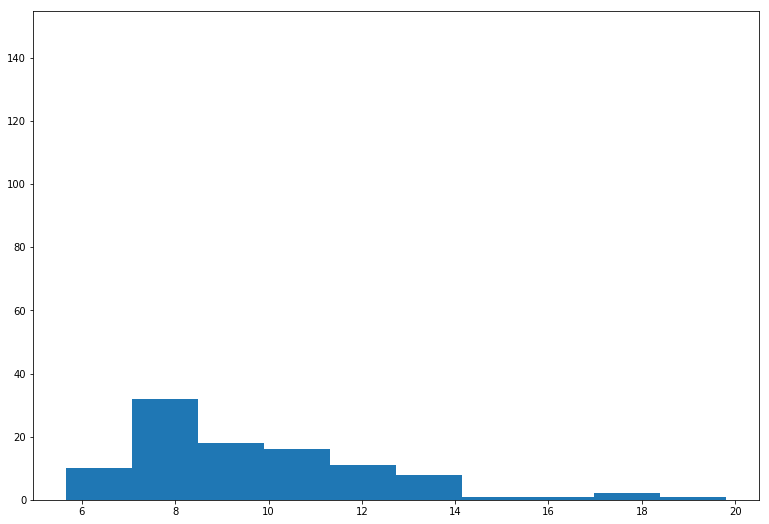

In [31]:
def get_model_outputs(net, data, softmax_margin=True, device=None):

    inputs, labels = data
    
    if device is not None:
        inputs, labels = inputs.to(device).type(torch.cuda.FloatTensor), labels.to(device).type(
            torch.cuda.LongTensor)
    else:
        inputs = inputs.float()

    outputs = net(inputs)
    
    if softmax_margin:
        m = torch.nn.Softmax(dim=-1)
        outputs = m(outputs)
        
    return outputs

def entropy(probs):
    return - np.sum([p * np.log(p) for p in probs])

def get_entropy(net, data, device=None):
    inputs, labels = data

    outputs = get_model_outputs(net, data, softmax_margin=True, device=device)
    outputs = outputs.detach().numpy()
    
    return [entropy(p) for p in outputs]

# def get_max_margin(net, datapoint):
#     inp, l = datapoint
    
#     loss = criterion(outputs, labels)
#     loss.backward(retain_graph=True)
    
#     param_grads = get_grad_params_vec(net)
#     curr_weight = torch.norm(param_grads)
        
# def get_nu(data):
#     tr = 0
#     for i in range(len(data[0])):
#         inputs, labels = data[0][i], data[1][i]
#         mean_inp = torch.mean(inputs)

#         for j in range()
    

def get_margins_to_correct(net, data, softmax_margin=True, device=None):
    inputs, labels = data

    outputs = get_model_outputs(net, data, softmax_margin, device)
    
    _, predicted = torch.max(outputs, 1)
    
    correct_filter = predicted == labels

        
    # if correctly predicted
    second_largest = torch.topk(outputs[correct_filter], k=2, dim=1)

    diff = second_largest[0][:, 0] - second_largest[0][:, 1]
    
    diff = diff.detach().numpy()

    return diff

def get_traces(net, data):
    criterion = torch.nn.CrossEntropyLoss()
    traces = []
    for i in range(len(data[0])):
        inputs, labels = data[0][i], data[1][i]
        traces.append(np.mean(hessian(net, criterion, data=(inputs.view(1, *inputs.shape), labels.view(1, *labels.shape)), cuda=False).trace()))

    return traces





net = exp_dict["models"]["1594044887.584526"][str(0)]

diff = get_margins_to_correct(net, data, softmax_margin=False)
# diff = get_entropy(net, data)
plt.hist(diff)
plt.ylim(0, 155)
plt.show()

In [32]:
a = time.time()
ts = get_traces(net, data)
print(time.time() - a)

309.91225600242615


In [33]:
net = exp_dict["models"]["1594045247.3381803"][str(0)] # large batch

a = time.time()
ts_1 = get_traces(net, data)
print(time.time() - a)

314.5018129348755


In [34]:
net = exp_dict["models"]["1594045247.3381803"][str(0)] # large batch

diff_1 = get_margins_to_correct(net, data, softmax_margin=False)
# diff_1 = get_entropy(net, data)


In [35]:


print("Trace sum first: {}".format(np.sum(ts)))
print("Trace sum second: {}".format(np.sum(ts_1)))

print()
for cutoff in np.linspace(5.5, 8, 20):
    print("Cutoff: {}".format(cutoff))
    f = diff < cutoff
    ts = np.array(ts)
    s = np.sum(f)
    print("Num Points first: {}".format(s))
    print("Mean Margin first: {}".format(np.mean(diff[f])))

    f_1 = diff_1 < cutoff
    ts_1 = np.array(ts_1)
    s_1 = np.sum(f_1)
    print("Num Points second: {}".format(s_1))
    print("Mean Margin second: {}".format(np.mean(diff_1[f_1])))



    print()

Trace sum first: 4646.4667647449105
Trace sum second: 6508.714931693764

Cutoff: 5.5
Num Points first: 0
Mean Margin first: nan
Num Points second: 1
Mean Margin second: 5.39609432220459

Cutoff: 5.631578947368421
Num Points first: 0
Mean Margin first: nan
Num Points second: 2
Mean Margin second: 5.462703227996826

Cutoff: 5.7631578947368425
Num Points first: 2
Mean Margin first: 5.670511245727539
Num Points second: 2
Mean Margin second: 5.462703227996826

Cutoff: 5.894736842105263
Num Points first: 2
Mean Margin first: 5.670511245727539
Num Points second: 2
Mean Margin second: 5.462703227996826

Cutoff: 6.026315789473684
Num Points first: 3
Mean Margin first: 5.781278133392334
Num Points second: 2
Mean Margin second: 5.462703227996826

Cutoff: 6.157894736842105
Num Points first: 4
Mean Margin first: 5.8579864501953125
Num Points second: 2
Mean Margin second: 5.462703227996826

Cutoff: 6.2894736842105265
Num Points first: 5
Mean Margin first: 5.9393110275268555
Num Points second: 3
Mean

<function matplotlib.pyplot.show(*args, **kw)>

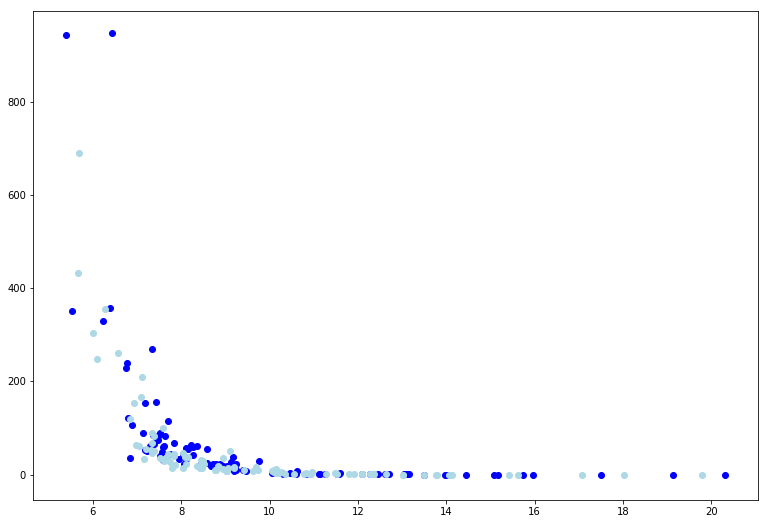

In [36]:
plt.scatter(diff, ts, color="lightblue")
plt.scatter(diff_1, ts_1, color="blue")


# plt.ylim(-0, 10)
# plt.xlim(0.006, 0.008)

plt.show